### Importing the necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,cross_val_predict, KFold,train_test_split,GridSearchCV,RandomizedSearchCV

First, we need to import the path with the raw data

Next, we import the data.

In [106]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [183]:
processed_test_store = pd.read_csv('/content/gdrive/My Drive/Documents/rossmann-store-sales/data/processed/processed_test_store_df.csv')
processed_train_store = pd.read_csv('/content/gdrive/My Drive/Documents/rossmann-store-sales/data/processed/processed_train_store_df.csv')

Let's have a look at how our data looks like.

In [184]:
processed_test_store.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,day,month,year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,o,0,17,9,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,857,1,3,2015-09-16,1.0,1,o,0,16,9,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1713,1,2,2015-09-15,1.0,1,o,0,15,9,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2569,1,1,2015-09-14,1.0,1,o,0,14,9,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,3425,1,7,2015-09-13,0.0,0,o,0,13,9,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [109]:
processed_train_store.head()

,Store,Date,day,month,year,DayOfWeek,WeekOfYear,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalePerCustomer
0,1,2015-07-31,31,7,2015,5,31,5263,555,1,1,o,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.482883
1,1,2015-07-30,30,7,2015,4,31,5020,546,1,1,o,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.194139
2,1,2015-07-29,29,7,2015,3,31,4782,523,1,1,o,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.143403
3,1,2015-07-28,28,7,2015,2,31,5011,560,1,1,o,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.948214
4,1,2015-07-27,27,7,2015,1,31,6102,612,1,1,o,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.970588


In [110]:
print("Shape of processed_train_store data is: ",processed_train_store.shape)
print("Shape of processed_test_store data is: ",processed_test_store.shape)

Shape of processed_train_store data is:  (844338, 23)
Shape of processed_test_store data is:  (41088, 20)


In [111]:
processed_train_store_dtypes = pd.DataFrame(processed_train_store.dtypes,
                                            columns = ["Data_type"])
processed_train_store_dtypes

,Data_type
Store,int64
Date,object
day,int64
month,int64
year,int64
DayOfWeek,int64
WeekOfYear,int64
Sales,int64
Customers,int64
Open,int64


In [112]:
#Checking for the unique values
unique_values = pd.DataFrame(columns=['Unique Values'])
for x in list(processed_train_store.columns.values):
    unique_values.loc[x] = [processed_train_store[x].nunique()]

In [113]:
unique_values

,Unique Values
Store,1115
Date,942
day,31
month,12
year,3
DayOfWeek,7
WeekOfYear,52
Sales,21733
Customers,4083
Open,1


Since our data is preprocessed, next we are going to extract some useful features from the `Date` variable that will be useful in our modelling.
* `Processed_train_store`
since for this dataframe we had day ,month and year extracted, we will just extract the week,the quarter and the seaon.

In [185]:
#converting the 'Date' column  to date formate
processed_train_store["Date"] = pd.to_datetime(processed_train_store["Date"],format = "%Y-%m-%d")

In [186]:
'''
We are going to consider for seasons;
ab)Summer runs from June 1 to August 31;
Fall (autumn) runs from September 1 to November 30; and
Winter runs from December 1 to February 28 (February 29 in a leap year).
'''
#Extracting.
processed_train_store["Week"] = processed_train_store["Date"].dt.week
processed_train_store["Quarter"] = processed_train_store["Date"].dt.quarter
processed_train_store["Season"] = np.where(processed_train_store["month"].isin([12,1,2]),"Winter",
                                    np.where(processed_train_store["month"].isin([6,7,8]),"Summer",
                                    np.where(processed_train_store["month"].isin([9,10,11]),"Fall",
                                    np.where(processed_train_store["month"].isin([3,4,5]),"Spring","None"))))

                                    #renaming the columns;
processed_train_store.rename(columns = {"year":"Year","day":"Day","month":"Month"},inplace = True)

#Creating new column from the above two
processed_train_store['CompetitionOpenSince'] = np.where((processed_train_store['CompetitionOpenSinceMonth']==0) & (processed_train_store['CompetitionOpenSinceYear']==0) , 
                                                  0,(processed_train_store.Month - processed_train_store.CompetitionOpenSinceMonth) + 
                                                  (12 * (processed_train_store.Year - processed_train_store.CompetitionOpenSinceYear)) )

In [187]:
#deleting date column as we hawe month, year and day from it
del processed_train_store["Date"]

In [188]:
processed_train_store.columns

Index(['Store', 'Day', 'Month', 'Year', 'DayOfWeek', 'WeekOfYear', 'Sales',
       'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'SalePerCustomer', 'Week', 'Quarter', 'Season', 'CompetitionOpenSince'],
      dtype='object')

In [189]:
processed_train_store['StateHoliday'] = processed_train_store['StateHoliday'].astype('category')
processed_train_store['Assortment'] = processed_train_store['Assortment'].astype('category')
processed_train_store['StoreType'] = processed_train_store['StoreType'].astype('category')
processed_train_store['PromoInterval']= processed_train_store['PromoInterval'].astype('category')
processed_train_store['Season']= processed_train_store['Season'].astype('category')

In [190]:
processed_train_store['StateHoliday_cat'] = processed_train_store['StateHoliday'].cat.codes
processed_train_store['Assortment_cat'] = processed_train_store['Assortment'].cat.codes
processed_train_store['StoreType_cat'] = processed_train_store['StoreType'].cat.codes
processed_train_store['PromoInterval_cat'] = processed_train_store['PromoInterval'].cat.codes
processed_train_store['Season_cat'] = processed_train_store['Season'].cat.codes

In [191]:
processed_train_store['StateHoliday_cat'] = processed_train_store['StateHoliday_cat'].astype('float')
processed_train_store['Assortment_cat'] = processed_train_store['Assortment_cat'].astype('float')
processed_train_store['StoreType_cat'] = processed_train_store['StoreType_cat'].astype('float')
processed_train_store['PromoInterval_cat'] = processed_train_store['PromoInterval_cat'].astype('float')
processed_train_store['Season_cat'] = processed_train_store['Season_cat'].astype('float')
processed_train_store.dtypes

Store                           int64
Day                             int64
Month                           int64
Year                            int64
DayOfWeek                       int64
WeekOfYear                      int64
Sales                           int64
Customers                       int64
Open                            int64
Promo                           int64
StateHoliday                 category
SchoolHoliday                   int64
StoreType                    category
Assortment                   category
CompetitionDistance           float64
CompetitionOpenSinceMonth     float64
CompetitionOpenSinceYear      float64
Promo2                          int64
Promo2SinceWeek               float64
Promo2SinceYear               float64
PromoInterval                category
SalePerCustomer               float64
Week                            int64
Quarter                         int64
Season                       category
CompetitionOpenSince          float64
StateHoliday

In [192]:
#now that CompetitionOpenSince is created 
#we can get rid of `CompetitionOpenSinceYear` and `CompeitionOpenSinceMonth`
del processed_train_store['CompetitionOpenSinceYear']
del processed_train_store['CompetitionOpenSinceMonth']

In [193]:
#Changing stateholiday column to a binary variable
processed_train_store["is_holiday_state"] = processed_train_store['StateHoliday'].map({"o": 0, "a": 1, "b": 1, "c": 1})

In [194]:
#changing categorical variables into dummies 
processed_train_store=pd.get_dummies(processed_train_store, columns=["Assortment", "StoreType","PromoInterval","Season"],
                              prefix=["is_Assortment", "is_StoreType","is_PromoInteval","is_Season"])

In [195]:
del processed_train_store['StateHoliday']
del processed_train_store['Assortment_cat']
del processed_train_store['StoreType_cat']
del processed_train_store['PromoInterval_cat']
del processed_train_store['Season_cat']
del processed_train_store['StateHoliday_cat']
processed_train_store.columns

Index(['Store', 'Day', 'Month', 'Year', 'DayOfWeek', 'WeekOfYear', 'Sales',
       'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SalePerCustomer',
       'Week', 'Quarter', 'CompetitionOpenSince', 'is_holiday_state',
       'is_Assortment_a', 'is_Assortment_b', 'is_Assortment_c',
       'is_StoreType_a', 'is_StoreType_b', 'is_StoreType_c', 'is_StoreType_d',
       'is_PromoInteval_0', 'is_PromoInteval_Feb,May,Aug,Nov',
       'is_PromoInteval_Jan,Apr,Jul,Oct', 'is_PromoInteval_Mar,Jun,Sept,Dec',
       'is_Season_Fall', 'is_Season_Spring', 'is_Season_Summer',
       'is_Season_Winter'],
      dtype='object')

* `Processed_test_store`
since for this dataframe we had day ,month and year extracted, we will just extract the week,the quarter and the seaon.

In [196]:
processed_test_store.rename(columns = {"year":"Year","day":"Day","month":"Month"},inplace = True)

In [197]:
#converting the 'Date' column  to date formate
processed_test_store["Date"] = pd.to_datetime(processed_test_store["Date"],format = "%Y-%m-%d")

In [198]:
'''
We are going to consider for seasons;
ab)Summer runs from June 1 to August 31;
Fall (autumn) runs from September 1 to November 30; and
Winter runs from December 1 to February 28 (February 29 in a leap year).
'''
#Extracting.
processed_test_store["Week"] = processed_test_store["Date"].dt.week
processed_test_store["Quarter"] = processed_test_store["Date"].dt.quarter
processed_test_store["Season"] = np.where(processed_test_store["Month"].isin([12,1,2]),"Winter",
                                    np.where(processed_test_store["Month"].isin([6,7,8]),"Summer",
                                    np.where(processed_test_store["Month"].isin([9,10,11]),"Fall",
                                    np.where(processed_test_store["Month"].isin([3,4,5]),"Spring","None"))))

processed_test_store['StateHoliday'] = processed_test_store['StateHoliday'].astype('category')
processed_test_store['Assortment'] = processed_test_store['Assortment'].astype('category')
processed_test_store['StoreType'] = processed_test_store['StoreType'].astype('category')
processed_test_store['PromoInterval']= processed_test_store['PromoInterval'].astype('category')
processed_test_store['Season']= processed_test_store['Season'].astype('category')

processed_test_store['StateHoliday_cat'] = processed_test_store['StateHoliday'].cat.codes
processed_test_store['Assortment_cat'] = processed_test_store['Assortment'].cat.codes
processed_test_store['StoreType_cat'] = processed_test_store['StoreType'].cat.codes
processed_test_store['PromoInterval_cat'] = processed_test_store['PromoInterval'].cat.codes
processed_test_store['Season_cat'] = processed_test_store['Season'].cat.codes

processed_test_store['StateHoliday_cat'] = processed_test_store['StateHoliday_cat'].astype('float')
processed_test_store['Assortment_cat'] = processed_test_store['Assortment_cat'].astype('float')
processed_test_store['StoreType_cat'] = processed_test_store['StoreType_cat'].astype('float')
processed_test_store['PromoInterval_cat'] = processed_test_store['PromoInterval_cat'].astype('float')
processed_test_store['Season_cat'] = processed_test_store['Season_cat'].astype('float')


processed_test_store['CompetitionOpenSince'] = np.where((processed_test_store['CompetitionOpenSinceMonth']==0) & 
                                                 (processed_test_store['CompetitionOpenSinceYear']==0) , 0,
                                                 (processed_test_store.Month - processed_test_store.CompetitionOpenSinceMonth) + 
                                       (12 * (processed_test_store.Year - processed_test_store.CompetitionOpenSinceYear)) )



processed_test_store["is_holiday_state"] = processed_test_store['StateHoliday'].map({"o": 0, "a": 1, "b": 1, "c": 1})




processed_test_store=pd.get_dummies(processed_test_store, columns=["Assortment", "StoreType","PromoInterval","Season"], 
                             prefix=["is_Assortment", "is_StoreType","is_PromoInteval","is_Season"])


In [199]:
del processed_test_store["Date"]
del processed_test_store['CompetitionOpenSinceYear']
del processed_test_store['CompetitionOpenSinceMonth']
del processed_test_store['StateHoliday_cat']
del processed_test_store['Assortment_cat']
del processed_test_store['StoreType_cat']
del processed_test_store['PromoInterval_cat']
del processed_test_store['StateHoliday']
del processed_test_store['Season_cat']

In [202]:
del processed_train_store['WeekOfYear']

**Developing The Model**

In this section of the project, I will develop a randomforestregressor training . Then ,we will make accurate evaluations of each model's performance (RandomForestRegressor vs XGBoostRegressor) through the use of the sklearn library which will help me evaluate which model is more suitable

**Defining a Performance Metric**

In [203]:
'''
For this project, we will use the rmspe(Root Mean Square Percentage Error) score provided as an evaluation metric for the model
'''
def rmspe(y, yhat):
    rmspe = np.sqrt(np.mean( (y - yhat)**2 ))
    return rmspe

Now we define the features and the target variable.

In [204]:
'''
a rule of thumb is to transform my target value to log if i see the values are very dispersed which is the case
and then of course revert them with np.exp to their real values
'''

features = processed_train_store.drop(['Customers', 'Sales', 'SalePerCustomer'], axis = 1) 
targets=np.log(processed_train_store.Sales)

Next we split the data for testing the model on a small part of the dataset.We call here train_test set which is usually divided 80% training and 20% validation.

In [205]:
from sklearn import model_selection
X_train, X_train_test, y_train, y_train_test = model_selection.train_test_split(features, targets, test_size=0.20, random_state=15)

In [206]:
X_train.is_holiday_state.fillna(0,inplace=True)
X_train_test.is_holiday_state.fillna(0,inplace=True)


In [207]:
X_train_test.isna().sum()

Store                               0
Day                                 0
Month                               0
Year                                0
DayOfWeek                           0
Open                                0
Promo                               0
SchoolHoliday                       0
CompetitionDistance                 0
Promo2                              0
Promo2SinceWeek                     0
Promo2SinceYear                     0
Week                                0
Quarter                             0
CompetitionOpenSince                0
is_holiday_state                    0
is_Assortment_a                     0
is_Assortment_b                     0
is_Assortment_c                     0
is_StoreType_a                      0
is_StoreType_b                      0
is_StoreType_c                      0
is_StoreType_d                      0
is_PromoInteval_0                   0
is_PromoInteval_Feb,May,Aug,Nov     0
is_PromoInteval_Jan,Apr,Jul,Oct     0
is_PromoInte

In [208]:
X_train_test.dtypes


Store                                 int64
Day                                   int64
Month                                 int64
Year                                  int64
DayOfWeek                             int64
Open                                  int64
Promo                                 int64
SchoolHoliday                         int64
CompetitionDistance                 float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
Week                                  int64
Quarter                               int64
CompetitionOpenSince                float64
is_holiday_state                      int64
is_Assortment_a                       uint8
is_Assortment_b                       uint8
is_Assortment_c                       uint8
is_StoreType_a                        uint8
is_StoreType_b                        uint8
is_StoreType_c                        uint8
is_StoreType_d                  

Training with RandomForest Regressor:
Definition: 
RandomForest is a machine learning alogrithm used for classification and regression that is bestly used with structured and tabular data.

In [209]:
#Define model
rfr = RandomForestRegressor(n_estimators=10, 
                             criterion='mse', 
                             max_depth=5, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4,
                             random_state=31, 
                             verbose=0, 
                             warm_start=False)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=4, oob_score=False,
                      random_state=31, verbose=0, warm_start=False)

Testing our RF on the validation set;

In [211]:
#training using cross validation set
rfr_val=RandomForestRegressor(n_estimators=128, 
                             criterion='mse', 
                             max_depth=20, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4, #setting n_jobs to 4 makes sure you're using the full potential of the machine you're running the training on
                             random_state=35, 
                             verbose=0, 
                             warm_start=False)
model_RF_test=rfr_val.fit(X_train,y_train)

Predicting our model;

In [213]:
yhat=model_RF_test.predict(X_train_test)

plotting;

(array([2.7000e+01, 2.6500e+02, 9.9900e+02, 6.1090e+03, 2.9496e+04,
        7.3368e+04, 4.6984e+04, 9.6920e+03, 1.8480e+03, 8.0000e+01]),
 array([ 6.53881147,  6.93174923,  7.324687  ,  7.71762476,  8.11056252,
         8.50350028,  8.89643805,  9.28937581,  9.68231357, 10.07525133,
        10.4681891 ]),
 <a list of 10 Patch objects>)

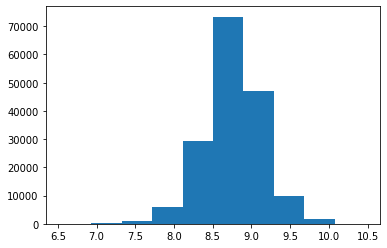

In [214]:
plt.hist(yhat)

Getting the loss function;

In [215]:
error=rmspe(y_train_test,yhat)

f"The number is {error:.3f}"

'The number is 0.164'

0.164 is trustworthy to be sure about the predictions of our model.

**Feature Importance**

feature importance gives us the opportunity to analyse what contributed to the accuracy of the model and what features were just noise. With this information we can check that the model is working as we would expect, discard features if we feel they are not adding any value and use it to hypothesis about new features that we could engineer for another iteration of the model.

In [230]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')


Now we have created the function it’s time to call it, passing the feature importance attribute array from the model, the feature names from our training dataset and also declaring the type of model for the title.

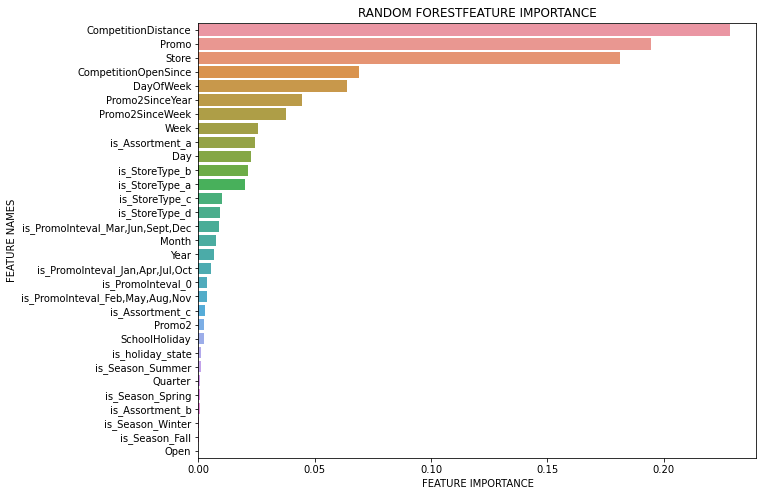

In [231]:
plot_feature_importance(rfr_val.feature_importances_,X_train.columns,'RANDOM FOREST')

A brief summary of our top important features in explaining sales;

**Competitor Distance**: This indeed impacts a lot the sales of a store .This was also seen in the analysis earlier that when competition is very far stores tend to sell a lot more.

**Promo**: Promotion is fundamental for a store to increase its sales, it allows price reduction which attracts more customers

**Store**: The Store itself represents a unique identificator for the algorithm to recognise which store has what attributes and indeed better accounts for the forecasting of those same stores in a future timeline.

Training XGboost Model

In [221]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [222]:
xg_reg.fit(X_train,y_train)

[21:37:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

(array([  571., 11546., 44122., 38926., 43170., 24528.,  5059.,   794.,
           81.,    71.]),
 array([5.598688 , 5.672878 , 5.747068 , 5.8212576, 5.8954473, 5.969637 ,
        6.043827 , 6.1180167, 6.1922064, 6.2663965, 6.340586 ],
       dtype=float32),
 <a list of 10 Patch objects>)

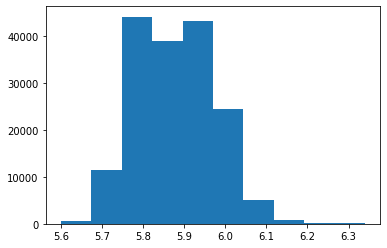

In [223]:
#prediciting and plotting the predictions
preds = xg_reg.predict(X_train_test)
plt.hist(preds)

In [225]:
error1=rmspe(y_train_test,preds)

f"The number is {error1:.3f}"

'The number is 2.905'

 when looking the loss function of the two models it is 
 Clearly seen that The Random regressor model perfom better with an error of **0.1611521960** whereas  XGBoost has a big error of **2.91**. 

To serve the models we built above, we need to serialize them so as to be able totrack predictions from various models.

In [ ]:
import pickle
# Saving model to disk
pickle.dump(rfr_val, open('21-8-2020-13-57.pkl','wb'))

In [ ]:
# Loading model to compare the results
model = pickle.load(open('21-8-2020-13-57','rb'))